<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://cloudsen12.github.io/thumbnails/cloudsen12.gif" width=10% >


>>>> *This notebook is part of the paper [CloudSEN12 - a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2](https://cloudsen12.github.io/); the content is available [on GitHub](https://github.com/cloudsen12)* and released under the [MIT](https://opensource.org/licenses/MIT) license. 

<br>

- See our paper [here](https://eartharxiv.org/repository/view/3615/).

- See cloudSEN12 website [here](https://cloudsen12.github.io/).

- See cloudSEN12 in Zenodo [here](https://zenodo.org/record/7034410).

- See cloudSEN12 in Google Drive [here](https://drive.google.com/drive/folders/1H_Qxy1yX6moqFbKc3Ajn4FFrHlDhYuz3).

- See cloudSEN12 in GitHub [here](https://github.com/cloudsen12).

- See cloudSEN12 in Google Earth Engine [here](https://samapriya.github.io/awesome-gee-community-datasets/projects/cloudsen12/).

- See CloudApp [here](https://csaybar.users.earthengine.app/view/cloudapp).

### **1. Install the cloudsen12 Python package**

In [1]:
!pip install cloudsen12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 31.2 MB/s 
     |████████████████████████████████| 146 kB 58.8 MB/s 
     |████████████████████████████████| 97 kB 9.8 MB/s 
     |████████████████████████████████| 47 kB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.9 MB 57.0 MB/s 
     |████████████████████████████████| 419 kB 71.6 MB/s 
     |████████████████████████████████| 6.3 MB 57.2 MB/s 
     |████████████████████████████████| 19.3 MB 532 kB/s 
     |████████████████████████████████| 58 kB 8.4 MB/s 
     |████████████████████████████████| 376 kB 68.4 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=dd86788df1fd1a7edcd21072ae027d2b229d1d694ab22d2d4189cb942273ba7d
  Stored in directory: /root/.cache/pip/wheel

In [2]:
import cloudsen12

### **2. Download a Sentinel-2 scene**

In [3]:
# Donwload S2 an create a TenSorSat object
productid = "S2A_MSIL1C_20190212T142031_N0207_R010_T19FDF_20190212T191443"
s2idpath = cloudsen12.download(productid, "/content/", quiet=False)

### **3. Create a Maskay dict object**

In [4]:
# Create a Maskay dict object
S2files = cloudsen12.MaskayDict(
    path=s2idpath,
    pattern="\.jp2$",
    full_names=True,
    recursive=True,
    sensor="Sentinel-2"
)
tensor = cloudsen12.TensorSat(**S2files.to_dict(), cache=True, align=False)

### **4. Make a prediction!**

In [5]:
# Make a prediction
model = cloudsen12.UnetMobV2()
predictor = cloudsen12.Predictor(
    cropsize=512,
    overlap=32,
    device="cuda", #cpu
    quiet=False,
)
result = predictor.predict(model, tensor)

Downloading...
From: https://drive.google.com/uc?id=1o9LeVsXCeD2jmS-G8s7ZISfciaP9v-DU
To: /root/.config/maskaymodels/unetmobv2.ckpt
100%|██████████| 80.0M/80.0M [00:01<00:00, 52.5MB/s]
100%|██████████| 529/529 [01:54<00:00,  4.63it/s]


### **5. Dispaly and save results!**

Text(0.5, 1.0, 'Cloud shadow prob <0-10000>')

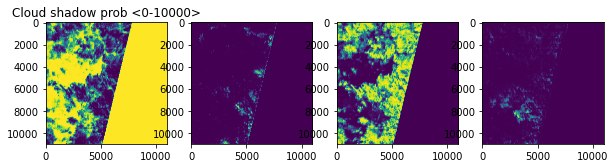

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(10, 40))

ax[0].imshow(result[0])
ax[0].set_title("Clear prob <0-10000>")
ax[1].imshow(result[1])
ax[0].set_title("Thick cloud prob <0-10000>")
ax[2].imshow(result[2])
ax[0].set_title("Thin cloud prob <0-10000>")
ax[3].imshow(result[3])
ax[0].set_title("Cloud shadow prob <0-10000>")

In [7]:
# Save results
result.rio.to_raster("/content/outensor.tif")